# <b style='color:yellow;'> KNN </b>
* Este Jupyter tem como função treinar um `KNN` com os melhores parametros determinados por um `RandomSearch`.

-> Treino com o dataset feminino com as semanas como targets.

---

Bibliotecas/Módulos

In [25]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import sys

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score, matthews_corrcoef, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

Configurações dos logs

In [2]:
logger = logging.getLogger("KNN")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter('%(name)s - %(levelname)s - [+] ------- %(message)s -------') 
handler.setFormatter(formatter)
logger.handlers = [handler]

Cores

In [3]:
RED = "\033[1;31m"
BLUE = "\033[1;34m"
GREEN = "\033[1;32m"
PINK = "\033[1;45m"
HEADER = '\033[95m'
OKBLUE = '\033[94m'
OKCYAN = '\033[96m'
OKGREEN = '\033[92m'
WARNING = '\033[93m'
FAIL = '\033[91m'
ENDC = '\033[0m'
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
MAG = "\033[1;45m"

## Preparando os dados

In [4]:
df = pd.read_csv("dados_FEM_10_voluntarios_c_semanas_15_sinais_noout.csv")

In [5]:
df.sample()

,0,1,2,3,4,5,6,7,8,9,...,1992,1993,1994,1995,1996,1997,1998,1999,label,semana
10527,-652,227,-136,-905,130,874,-100,-902,20,903,...,-664,806,-482,-168,705,774,-830,482,1,4


Removendo possíveis linhas vazias

In [6]:
df = df.dropna()

Verificando o tamanho do dataset

In [7]:
len(df)

18000

Verificando a quantidade de colunas originais

In [8]:
len(df.columns)

2002

* Seleção da variaveis target e das features

In [9]:
y = df["semana"]

In [10]:
df = df.drop(["semana"], axis=1)

#### PCA
Aplicando o PCA para reduzir a dimensão dos dados.

In [12]:
pca = PCA(n_components=1000)

In [13]:
pca.fit(df)

PCA(n_components=1000)

In [14]:
%%time

pca_samples = pca.transform(df)

CPU times: user 16.1 s, sys: 12.1 s, total: 28.2 s
Wall time: 2.2 s


In [15]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-31.426972,19.593266,66.149497,5.087693,-145.755438,-60.110903,-95.581629,8.489667,-73.231320,-43.579136,...,6.957283,9.481153,-3.096726,-7.911625,-1.053373,-15.417675,15.268691,-4.813609,-21.000636,-8.999886
1,-67.161373,33.442037,43.310118,-14.236839,-144.593542,-12.403398,-98.242895,-2.547335,-69.538878,-37.210569,...,-3.137596,9.761738,2.631848,1.030005,-2.067660,-11.306595,6.221301,-1.784449,-32.051260,-9.184076
2,-93.019930,35.557195,5.966039,-26.539077,-151.494378,32.550934,-112.608380,-15.639923,-59.108039,-28.130038,...,-10.552779,3.926208,8.437100,-0.257694,-20.207291,-8.589127,-9.911673,13.470491,-45.363286,-3.169706
3,-114.755784,34.779378,-10.552657,-39.481854,-145.625364,72.526742,-111.402247,-35.211066,-48.914545,-12.286798,...,-13.065232,3.593795,18.647468,5.197012,-18.790997,-11.610972,-23.419264,9.552473,-50.585766,-10.371877
4,-111.867249,44.544022,-26.877515,-47.197607,-135.394425,97.920772,-85.358632,-53.932529,-39.548346,-1.877483,...,-17.027806,1.497911,16.637596,0.367614,-16.167997,-6.373605,-16.499268,7.241257,-43.682823,-2.117236


In [16]:
len(ps)

18000

In [17]:
len(ps.columns)

1000

In [18]:
X = ps

Separando os dados em dados de treino e teste

In [19]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=7)

#### Scaler

Aplicando Scaler para diminuir a diferença entre a maginitude dos dados, pois isso pode afetar muito o KNN

In [20]:
scaler = StandardScaler()  
scaler.fit(x_treino)

x_treino = scaler.transform(x_treino)  
x_teste = scaler.transform(x_teste)

---

## Treinamento

### Método do cotovelo

Além de escolher os melhores parâmetros no KNN é necessário também escolher o melhor valor para a quantidade de k-vizinhos.
Para isso será utilizado o método do cotovelo.

In [23]:
error = []

for i in range(1, 20):  
    knn = KNeighborsClassifier(n_neighbors=i, algorithm= "ball_tree")
    
    logger.info("Fitando modelo")
    knn.fit(x_treino, y_treino)
    pred_i = knn.predict(x_teste)
    error.append(np.mean(pred_i != y_teste))

Text(0, 0.5, 'Mean Error')

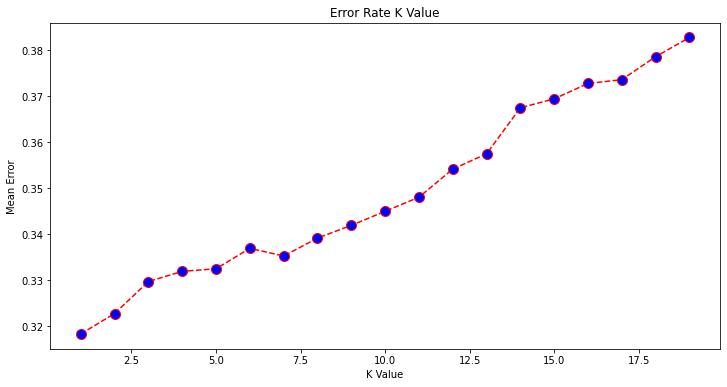

In [24]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 20), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

Conforme observado, quanto maior a quantidade de k-vizinhos, maior o erro.

----

### KNN

In [26]:
def classificador(x_treino: np.array, y_treino: np.array, x_teste: np.array, y_teste: np.array) -> list:
    '''
        Treina um classificador com os melhores parametros possíveis.
        
        Params
        ------
        :x_treino: dados de treino
        :x_teste: dados de teste
        :y_treino: dados de treino -labels
        :y_teste: dados de treino - labels
    
        Return
        ------
        :KNN: Modelo KNN treinado
        :resultados: métricas
    '''
    
    logger.info('Instanciando KNN')
   
    KNN = KNeighborsClassifier(n_neighbors=1, algorithm= "ball_tree")
    
    logger.info('Treinando KNN')
    KNN.fit(x_treino, y_treino)
    
    logger.info('Predict')
    p = KNN.predict_proba(x_teste)[:, 1]
    categorias = KNN.predict(x_teste)
    
    logger.info('Métricas: \n \n')
    
    logger.info('Acurácia')
    acc = accuracy_score(y_teste, categorias)
    print(OKCYAN, "Acc \n" + str(acc) + "\n")
    
    logger.info("F1")
    f1 = f1_score(y_teste, categorias, average="weighted")
    print(GREEN, "F1 \n" + str(f1) + "\n")
    
    logger.info("Mcc")
    mcc = matthews_corrcoef(y_teste, categorias)
    print(WARNING, "Mcc \n" + str(mcc) + "\n")
    
    logger.info('Class Report')
    resultados = classification_report(y_teste, categorias)
    print(ENDC, "Class Report \n" + resultados + "\n")
    
    mat = confusion_matrix(y_teste, categorias)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    return KNN, resultados

SVM - INFO - [+] ------- Instanciando KNN -------
SVM - INFO - [+] ------- Treinando KNN -------
SVM - INFO - [+] ------- Predict -------
SVM - INFO - [+] ------- Métricas: 
 
 -------
SVM - INFO - [+] ------- Acurácia -------
SVM - INFO - [+] ------- F1 -------
SVM - INFO - [+] ------- Mcc -------
SVM - INFO - [+] ------- Class Report -------
SVM - INFO - [+] ------- Ok -------
SVM - INFO - [+] ------- Treino finalizado -------


 Acc 
0.6816666666666666

 F1 
0.6834931228255589

 Mcc 
0.5785392044017921

 Class Report 
              precision    recall  f1-score   support

           1       0.60      0.72      0.66       865
           2       0.76      0.62      0.69       890
           3       0.78      0.67      0.72       945
           4       0.62      0.71      0.66       900

    accuracy                           0.68      3600
   macro avg       0.69      0.68      0.68      3600
weighted avg       0.70      0.68      0.68      3600


CPU times: user 2min 23s, sys: 4.82 s, total: 2min 27s
Wall time: 2min 27s


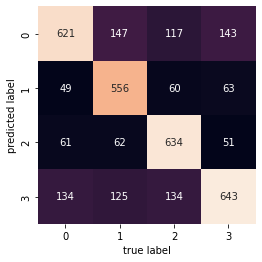

In [27]:
%%time

try:
    KNN, resultados = classificador(
                        x_treino,
                        y_treino,
                        x_teste,
                        y_teste)

except Exception as error:
    logger.warning('Aconteceu algum problema...')
    logger.critical(error)

else:
    logger.info('Ok')
    
finally:
    logger.info('Treino finalizado')

Quanto maior a quantidade de vizinhos analizados maior o erro

----

#### Exportando modelo

In [28]:
pkl.dump(KNN, open('modelos/knn_dados_FEM_10_voluntarios_c_semanas_15_sinais_noout.pkl', 'wb'))